Import all necessary libraries and install everything you need for training:

In [2]:
# install the libraries necessary for data wrangling, prediction and result analysis
import json
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score,precision_score, recall_score
import torch
from numba import cuda
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

In [2]:
# Install transformers
# (this needs to be done on Kaggle each time you start the session)
#!pip install -q transformers

In [3]:
# Install the simpletransformers
#!pip install -q simpletransformers
from simpletransformers.classification import ClassificationModel

In [4]:
# Install wandb
#!pip install -q wandb

In [4]:
import wandb

In [5]:
# Login to wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tajak (use `wandb login --relogin` to force relogin)


True

In [6]:
# Clean the GPU cache

cuda.select_device(0)
cuda.close()
cuda.select_device(0)
torch.cuda.empty_cache()


### Import the data

In [7]:
# CORE-sub (texts annotated with CORE subcategories)
train_df = pd.read_csv("data-splits/CORE-sub-subset-train.csv", index_col = 0)
dev_df = pd.read_csv("data-splits/CORE-sub-subset-dev.csv", index_col = 0)
test_df = pd.read_csv("data-splits/CORE-sub-subset-test.csv", index_col = 0)

print("CORE-sub train shape: {}, Dev shape: {}, Test shape: {}.".format(train_df.shape, dev_df.shape, test_df.shape))

CORE-sub train shape: (9537, 2), Dev shape: (3179, 2), Test shape: (3179, 2).


In [8]:
train_df.head()

,text,labels
43748,"Rahm Sues Teachers Because They Want to Read, ...",News Report/Blog
3896,Justice: People Who Are Homeless STORIES Julia...,Description of a Thing
2267,WAN (Wide Area Network) Solutions provide clie...,Description with Intent to Sell
37080,Press Room ICYMI: Univisin Anchor Jorge Ramos'...,Opinion Blog
13072,McGlynn focusing on football Hearts manager Jo...,Sports Report


## Testing

We will use the multilingual XLM-RoBERTa model
https://huggingface.co/xlm-roberta-base

In [8]:
# Create a file to save results into (you can find it under Data: Output). Be careful, run this step only once to not overwrite the results file.
results = []

with open("results/CORE-main-Experiments-Results.json", "w") as results_file:
    json.dump(results,results_file, indent= "")

In [9]:
# Open the main results file:

previous_results_file = open("results/CORE-main-Experiments-Results.json")
previous_results = json.load(previous_results_file)
len(previous_results)

2

In [10]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [11]:
# Create a list of labels
LABELS = train_df.labels.unique().tolist()
LABELS

['News Report/Blog',
 'Description of a Thing',
 'Description with Intent to Sell',
 'Opinion Blog',
 'Sports Report',
 'Question/Answer Forum',
 'Personal Blog',
 'Discussion Forum',
 'Advice',
 'Historical Article',
 'Reviews',
 'Recipe',
 'Information Blog',
 'Interview',
 'How-to',
 'Description of a Person',
 'Formal Speech',
 'Religious Blogs/Sermons',
 'Song Lyrics',
 'Short Story',
 'FAQ about Information',
 'Travel Blog',
 'Research Article',
 'Encyclopedia Article',
 'Persuasive Article or Essay',
 'Transcript of Video/Audio',
 'Poem',
 'Legal terms',
 'Course Materials',
 'Technical Support',
 'Magazine Article',
 'Other Information',
 'Reader/Viewer Responses',
 'Editorial',
 'FAQ about How-to',
 'Technical Report',
 'Letter to Editor']

In [12]:
# Initialize Wandb
run = wandb.init(project="CORE-hyperparameter-search", entity="tajak", name="testing-trained-model")

In [13]:
# Download the model from Wandb
artifact = run.use_artifact('tajak/CORE-hyperparameter-search/CORE-sub-classifier:v0', type='model')
artifact_dir = artifact.download()

# Loading a local save
model = ClassificationModel(
    "xlmroberta", artifact_dir)

wandb: Downloading large artifact CORE-sub-classifier:v0, 1081.97MB. 8 files... Done. 0:0:0
/home/tajak/anaconda3/lib/python3.9/site-packages/simpletransformers/classification/classification_model.py:459: UserWarning: use_multiprocessing automatically disabled as xlmroberta fails when using multiprocessing for feature conversion.
  warnings.warn(


In [14]:
def testing(test_df, test_name):
    """
    This function takes the test dataset and applies the trained model on it to infer predictions.
    It also prints and saves a confusion matrix, calculates the F1 scores and saves the results in a list of results.

    Args:
    - test_df (pandas DataFrame)
    - test_name
    """
    # Get the true labels
    y_true = test_df.labels
    
    # Calculate the model's predictions on test
    def make_prediction(input_string):
        return model.predict([input_string])[0][0]

    y_pred = test_df.text.apply(make_prediction)
    test_df["y_pred_CORE_sub"] = y_pred

    # Calculate the scores
    macro = f1_score(y_true, y_pred, labels=LABELS, average="macro")
    micro = f1_score(y_true, y_pred, labels=LABELS,  average="micro")
    print(f"Macro f1: {macro:0.3}, Micro f1: {micro:0.3}")

    # Plot the confusion matrix:
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    plt.figure(figsize=(9, 9))
    plt.imshow(cm, cmap="Oranges")
    for (i, j), z in np.ndenumerate(cm):
        plt.text(j, i, '{:d}'.format(z), ha='center', va='center')
    classNames = LABELS
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=90)
    plt.yticks(tick_marks, classNames)
    plt.title(f"{test_name}")

    plt.tight_layout()
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    fig1.savefig(f"figures/Confusion-matrix-{test_name}.png",dpi=100)

    # Save the results:
    rezdict = {
        "experiment": test_name,
        "num_train_epochs": 6,
        "train_batch_size":8,
        "learning_rate": 1e-5,
        "microF1": micro,
        "macroF1": macro,
        "y_true": y_true.to_dict(),
        "y_pred": y_pred.to_dict(),
        }
    previous_results.append(rezdict)

    #Save intermediate results (just in case)
    backup = []
    backup.append(rezdict)
    with open(f"backup-results-{test_name}.json", "w") as backup_file:
        json.dump(backup,backup_file, indent= "")

    # Save the new dataframe which contains the y_pred values as well
    test_df.to_csv(f"results/{test_name}-sheet-with-predictions.csv", sep="\t")

Macro f1: 0.396, Micro f1: 0.662


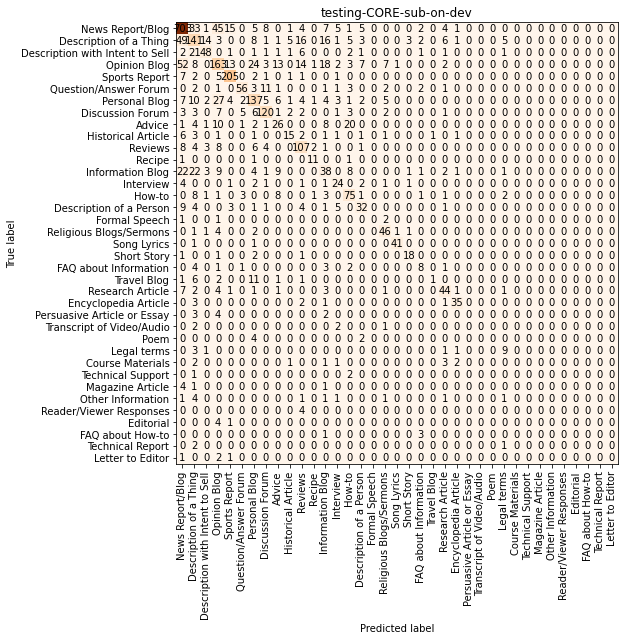


Testing finished.


<Figure size 432x288 with 0 Axes>

In [15]:
testing(dev_df, "testing-CORE-sub-on-dev")

print("\nTesting finished.")

Macro f1: 0.394, Micro f1: 0.661


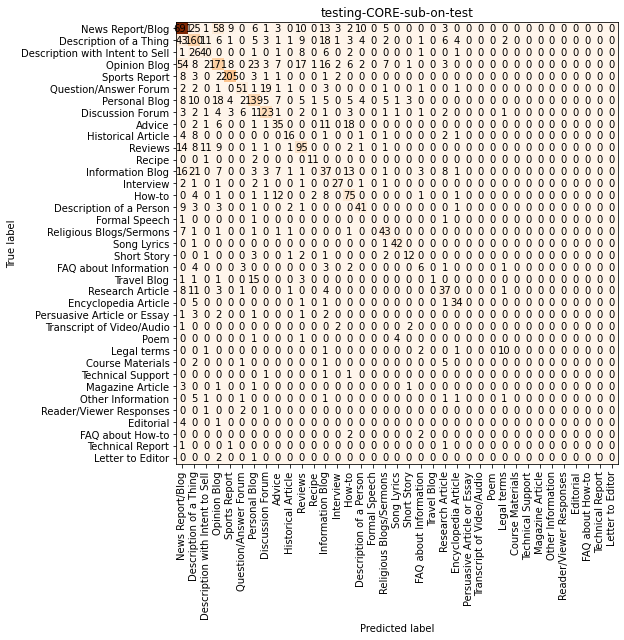


Testing finished.


<Figure size 432x288 with 0 Axes>

In [16]:
testing(test_df, "testing-CORE-sub-on-test")
print("\nTesting finished.")

In [17]:
# Compare the results by creating a dataframe from the previous_results dictionary:
results_df = pd.DataFrame(previous_results)

results_df

,experiment,num_train_epochs,train_batch_size,learning_rate,microF1,macroF1,y_true,y_pred
0,testing-CORE-main-on-dev,4,8,0.00001,0.736180,0.623031,"{'6282': 'Narrative', '7725': 'Narrative', '18...","{'6282': 'Narrative', '7725': 'Narrative', '18..."
1,testing-CORE-main-on-test,4,8,0.00001,0.744662,0.620480,{'32898': 'Informational Description/Explanati...,{'32898': 'Informational Description/Explanati...
2,testing-CORE-sub-on-dev,6,8,0.00001,0.661529,0.395807,"{30471: 'News Report/Blog', 29668: 'Sports Rep...","{30471: 'News Report/Blog', 29668: 'Sports Rep..."
3,testing-CORE-sub-on-test,6,8,0.00001,0.661214,0.394314,"{18157: 'Personal Blog', 38004: 'Opinion Blog'...","{18157: 'Opinion Blog', 38004: 'Sports Report'..."


In [18]:
# Save the file with updated results.
with open("results/CORE-main-Experiments-Results.json", "w") as results_file:
    json.dump(previous_results,results_file, indent= "")

## Predict CORE labels to other datasets

In [19]:
# Create a function to predict
def predict_CORE(df, new_file_name):
    """
    This function takes a dataset and applies the trained model on it to infer predictions.
	It returns and saves the resulting df with added columns with CORE predictions.

    Args:
    - df: dataframe on which we want to apply prediction. The text should be in a column "text".
    - new_file_name: define the name of the new file
    """
    # Predict on the df
    def make_prediction(input_string):
        return model.predict([input_string])[0][0]

    y_pred = df.text.apply(make_prediction)

    df["CORE_sub_pred"] = y_pred

    # Save the new dataframe which contains the y_pred values as well
    df.to_csv(f"{new_file_name}", sep="\t")

    return df

Prediction takes around 22 minutes per 1000 instances.

### Predict CORE to GINCO

In [20]:
# Import data about GINCO
ginco_df = pd.read_csv("data-sheets-with-all-info/GINCO-MT-GINCO-keeptext-with-all-information.csv", sep="\t", index_col=0)
ginco_df

,id,url,crawled,hard,primary_level_1,primary_level_2,primary_level_3,secondary_level_1,secondary_level_2,secondary_level_3,...,Slovene_text,MT_text,text_length,FTD_pred_on_SL,FTD_pred_on_MT,split-without-rare-categories,primary_level_4,downcast_split,CORE_main_pred_on_SL,CORE_main_pred_on_MT
0,3949,http://www.pomurje.si/aktualno/sport/zimska-li...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,...,"Šport <p/> Zimska liga malega nogometa sobota,...",Sport <p/> Winter Little League Football Satur...,93,A8 (news),A8 (news),test,News/Reporting,test,Narrative,Narrative
1,3726,http://www.ss-sezana.si/sss/index.php?option=c...,2014,False,Information/Explanation,Information/Explanation,Information/Explanation,NaN,NaN,NaN,...,JEDILNIK <p/> Iskalnik <p/> Poglavitni cilj pr...,JEDILNIK <p/> Search <p/> The main objective o...,76,A16 (information),A16 (information),test,Information/Explanation,dev,Informational Description/Explanation,Informational Description/Explanation
2,5621,http://www.kamnik-starejsi.si/novice/144-sodel...,2014,False,Promotion of Services,Promotion of Services,Promotion,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,...,Projekt INNOVAge in zavod Oreli <p/> Zavod Ore...,Project INNOVAge and the Oreli Institute <p/> ...,232,A12 (promotion),A12 (promotion),train,Promotion,test,Informational Description/Explanation,Informational Description/Explanation
3,3776,http://www.radiocelje.si/novica.php?id=13007&a...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,...,"V novembru, mesecu preprečevanja odvisnosti, b...","In November, the month of addiction prevention...",158,A8 (news),A8 (news),train,News/Reporting,train,Informational Description/Explanation,Informational Description/Explanation
4,2102,http://www.mtv.si/novice/selena-gomez-ponudila...,2014,False,Opinionated News,Opinionated News,Opinionated News,NaN,NaN,NaN,...,Selena Gomez ponudila v poslušanje novi album ...,Selena Gomez launches new album <p/> 16.07.201...,63,A8 (news),A8 (news),test,News/Reporting,train,Narrative,Narrative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,374730,http://khetanes.si/sl-si/produkti/projektne-no...,2021,False,Information/Explanation,Information/Explanation,Information/Explanation,NaN,NaN,NaN,...,Projektne novine <p/> Promocijski projektni ča...,Project News <p/> Promotional project newspape...,86,A12 (promotion),A8 (news),test,Information/Explanation,test,Informational Description/Explanation,Informational Description/Explanation
998,476885,https://www.merkur.si/navigacija/nasveti/kopal...,2021,False,List of Summaries/Excerpts,List of Summaries/Excerpts,List of Summaries/Excerpts,NaN,NaN,NaN,...,V raznoliki ponudbi tušev izberite popolno raz...,Choose the perfect shower to match your taste ...,50,A12 (promotion),A12 (promotion),train,List of Summaries/Excerpts,train,Informational Persuasion,Informational Persuasion
999,674213,http://www.sex2.si/category/ocene-izdelkov/,2021,False,List of Summaries/Excerpts,List of Summaries/Excerpts,List of Summaries/Excerpts,NaN,NaN,NaN,...,"O izdelku Za znamko Dame stojita dve ženski, z...",About the product There are two women behind t...,295,A12 (promotion),A12 (promotion),train,List of Summaries/Excerpts,train,Informational Persuasion,Informational Persuasion
1000,975590,http://www.ipsos.si/VodenjeVIZ_VI_past_dvojne_...,2021,False,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,NaN,NaN,NaN,...,Razprava pogosto potegne na plano najprej tist...,The debate often brings to the surface first t...,409,A1 (argumentative),A1 (argumentative),dev,Opinion/Argumentation,train,Informational Description/Explanation,Informational Description/Explanation


In [21]:
# First, use the Slovene data - rename the column with slovene text to "text"
ginco_df = ginco_df.rename(columns= {"Slovene_text": "text"})
ginco_df.head(1)

,id,url,crawled,hard,primary_level_1,primary_level_2,primary_level_3,secondary_level_1,secondary_level_2,secondary_level_3,...,text,MT_text,text_length,FTD_pred_on_SL,FTD_pred_on_MT,split-without-rare-categories,primary_level_4,downcast_split,CORE_main_pred_on_SL,CORE_main_pred_on_MT
0,3949,http://www.pomurje.si/aktualno/sport/zimska-li...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,...,"Šport <p/> Zimska liga malega nogometa sobota,...",Sport <p/> Winter Little League Football Satur...,93,A8 (news),A8 (news),test,News/Reporting,test,Narrative,Narrative


In [22]:
# Apply predictions
ginco_df = predict_CORE(ginco_df, "GINCO-MT-GINCO-keeptext-with-all-information-sl-text.csv")

In [23]:
ginco_df

,id,url,crawled,hard,primary_level_1,primary_level_2,primary_level_3,secondary_level_1,secondary_level_2,secondary_level_3,...,MT_text,text_length,FTD_pred_on_SL,FTD_pred_on_MT,split-without-rare-categories,primary_level_4,downcast_split,CORE_main_pred_on_SL,CORE_main_pred_on_MT,CORE_sub_pred
0,3949,http://www.pomurje.si/aktualno/sport/zimska-li...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,...,Sport <p/> Winter Little League Football Satur...,93,A8 (news),A8 (news),test,News/Reporting,test,Narrative,Narrative,Sports Report
1,3726,http://www.ss-sezana.si/sss/index.php?option=c...,2014,False,Information/Explanation,Information/Explanation,Information/Explanation,NaN,NaN,NaN,...,JEDILNIK <p/> Search <p/> The main objective o...,76,A16 (information),A16 (information),test,Information/Explanation,dev,Informational Description/Explanation,Informational Description/Explanation,Description of a Thing
2,5621,http://www.kamnik-starejsi.si/novice/144-sodel...,2014,False,Promotion of Services,Promotion of Services,Promotion,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,...,Project INNOVAge and the Oreli Institute <p/> ...,232,A12 (promotion),A12 (promotion),train,Promotion,test,Informational Description/Explanation,Informational Description/Explanation,Description of a Thing
3,3776,http://www.radiocelje.si/novica.php?id=13007&a...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,...,"In November, the month of addiction prevention...",158,A8 (news),A8 (news),train,News/Reporting,train,Informational Description/Explanation,Informational Description/Explanation,News Report/Blog
4,2102,http://www.mtv.si/novice/selena-gomez-ponudila...,2014,False,Opinionated News,Opinionated News,Opinionated News,NaN,NaN,NaN,...,Selena Gomez launches new album <p/> 16.07.201...,63,A8 (news),A8 (news),test,News/Reporting,train,Narrative,Narrative,News Report/Blog
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,374730,http://khetanes.si/sl-si/produkti/projektne-no...,2021,False,Information/Explanation,Information/Explanation,Information/Explanation,NaN,NaN,NaN,...,Project News <p/> Promotional project newspape...,86,A12 (promotion),A8 (news),test,Information/Explanation,test,Informational Description/Explanation,Informational Description/Explanation,Description of a Thing
998,476885,https://www.merkur.si/navigacija/nasveti/kopal...,2021,False,List of Summaries/Excerpts,List of Summaries/Excerpts,List of Summaries/Excerpts,NaN,NaN,NaN,...,Choose the perfect shower to match your taste ...,50,A12 (promotion),A12 (promotion),train,List of Summaries/Excerpts,train,Informational Persuasion,Informational Persuasion,Description with Intent to Sell
999,674213,http://www.sex2.si/category/ocene-izdelkov/,2021,False,List of Summaries/Excerpts,List of Summaries/Excerpts,List of Summaries/Excerpts,NaN,NaN,NaN,...,About the product There are two women behind t...,295,A12 (promotion),A12 (promotion),train,List of Summaries/Excerpts,train,Informational Persuasion,Informational Persuasion,Description with Intent to Sell
1000,975590,http://www.ipsos.si/VodenjeVIZ_VI_past_dvojne_...,2021,False,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,NaN,NaN,NaN,...,The debate often brings to the surface first t...,409,A1 (argumentative),A1 (argumentative),dev,Opinion/Argumentation,train,Informational Description/Explanation,Informational Description/Explanation,FAQ about Information


In [24]:
# Let's also apply the predictions to the MT GINCO set
ginco_df = ginco_df.rename(columns={"text":"Slovene_text", "CORE_sub_pred":"CORE_sub_pred_on_SL"})
ginco_df = ginco_df.rename(columns={"MT_text":"text"})

In [25]:
ginco_df.head(1)

,id,url,crawled,hard,primary_level_1,primary_level_2,primary_level_3,secondary_level_1,secondary_level_2,secondary_level_3,...,text,text_length,FTD_pred_on_SL,FTD_pred_on_MT,split-without-rare-categories,primary_level_4,downcast_split,CORE_main_pred_on_SL,CORE_main_pred_on_MT,CORE_sub_pred_on_SL
0,3949,http://www.pomurje.si/aktualno/sport/zimska-li...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,...,Sport <p/> Winter Little League Football Satur...,93,A8 (news),A8 (news),test,News/Reporting,test,Narrative,Narrative,Sports Report


In [26]:
ginco_df = predict_CORE(ginco_df, "GINCO-MT-GINCO-keeptext-with-all-information-2.csv")

In [27]:
ginco_df

,id,url,crawled,hard,primary_level_1,primary_level_2,primary_level_3,secondary_level_1,secondary_level_2,secondary_level_3,...,text_length,FTD_pred_on_SL,FTD_pred_on_MT,split-without-rare-categories,primary_level_4,downcast_split,CORE_main_pred_on_SL,CORE_main_pred_on_MT,CORE_sub_pred_on_SL,CORE_sub_pred
0,3949,http://www.pomurje.si/aktualno/sport/zimska-li...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,...,93,A8 (news),A8 (news),test,News/Reporting,test,Narrative,Narrative,Sports Report,Sports Report
1,3726,http://www.ss-sezana.si/sss/index.php?option=c...,2014,False,Information/Explanation,Information/Explanation,Information/Explanation,NaN,NaN,NaN,...,76,A16 (information),A16 (information),test,Information/Explanation,dev,Informational Description/Explanation,Informational Description/Explanation,Description of a Thing,Description of a Thing
2,5621,http://www.kamnik-starejsi.si/novice/144-sodel...,2014,False,Promotion of Services,Promotion of Services,Promotion,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,...,232,A12 (promotion),A12 (promotion),train,Promotion,test,Informational Description/Explanation,Informational Description/Explanation,Description of a Thing,Description of a Thing
3,3776,http://www.radiocelje.si/novica.php?id=13007&a...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,...,158,A8 (news),A8 (news),train,News/Reporting,train,Informational Description/Explanation,Informational Description/Explanation,News Report/Blog,News Report/Blog
4,2102,http://www.mtv.si/novice/selena-gomez-ponudila...,2014,False,Opinionated News,Opinionated News,Opinionated News,NaN,NaN,NaN,...,63,A8 (news),A8 (news),test,News/Reporting,train,Narrative,Narrative,News Report/Blog,News Report/Blog
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,374730,http://khetanes.si/sl-si/produkti/projektne-no...,2021,False,Information/Explanation,Information/Explanation,Information/Explanation,NaN,NaN,NaN,...,86,A12 (promotion),A8 (news),test,Information/Explanation,test,Informational Description/Explanation,Informational Description/Explanation,Description of a Thing,Description of a Thing
998,476885,https://www.merkur.si/navigacija/nasveti/kopal...,2021,False,List of Summaries/Excerpts,List of Summaries/Excerpts,List of Summaries/Excerpts,NaN,NaN,NaN,...,50,A12 (promotion),A12 (promotion),train,List of Summaries/Excerpts,train,Informational Persuasion,Informational Persuasion,Description with Intent to Sell,Description with Intent to Sell
999,674213,http://www.sex2.si/category/ocene-izdelkov/,2021,False,List of Summaries/Excerpts,List of Summaries/Excerpts,List of Summaries/Excerpts,NaN,NaN,NaN,...,295,A12 (promotion),A12 (promotion),train,List of Summaries/Excerpts,train,Informational Persuasion,Informational Persuasion,Description with Intent to Sell,Description with Intent to Sell
1000,975590,http://www.ipsos.si/VodenjeVIZ_VI_past_dvojne_...,2021,False,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,NaN,NaN,NaN,...,409,A1 (argumentative),A1 (argumentative),dev,Opinion/Argumentation,train,Informational Description/Explanation,Informational Description/Explanation,FAQ about Information,Question/Answer Forum


In [28]:
# Let's save the final version
ginco_df = ginco_df.rename(columns={"text":"MT_text", "CORE_sub_pred":"CORE_sub_pred_on_MT"})

ginco_df.to_csv("data-sheets-with-all-info/GINCO-MT-GINCO-keeptext-with-all-information.csv", sep="\t")

In [29]:
ginco_df.head(1)

,id,url,crawled,hard,primary_level_1,primary_level_2,primary_level_3,secondary_level_1,secondary_level_2,secondary_level_3,...,text_length,FTD_pred_on_SL,FTD_pred_on_MT,split-without-rare-categories,primary_level_4,downcast_split,CORE_main_pred_on_SL,CORE_main_pred_on_MT,CORE_sub_pred_on_SL,CORE_sub_pred_on_MT
0,3949,http://www.pomurje.si/aktualno/sport/zimska-li...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,...,93,A8 (news),A8 (news),test,News/Reporting,test,Narrative,Narrative,Sports Report,Sports Report


In [30]:
# Analyse in how many cases do the labels on SL and MT text differ
ginco_df["agreement"] = np.where((ginco_df["CORE_sub_pred_on_SL"] != ginco_df["CORE_sub_pred_on_MT"]), "no", "yes")

ginco_df.head(3)

,id,url,crawled,hard,primary_level_1,primary_level_2,primary_level_3,secondary_level_1,secondary_level_2,secondary_level_3,...,FTD_pred_on_SL,FTD_pred_on_MT,split-without-rare-categories,primary_level_4,downcast_split,CORE_main_pred_on_SL,CORE_main_pred_on_MT,CORE_sub_pred_on_SL,CORE_sub_pred_on_MT,agreement
0,3949,http://www.pomurje.si/aktualno/sport/zimska-li...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,...,A8 (news),A8 (news),test,News/Reporting,test,Narrative,Narrative,Sports Report,Sports Report,yes
1,3726,http://www.ss-sezana.si/sss/index.php?option=c...,2014,False,Information/Explanation,Information/Explanation,Information/Explanation,NaN,NaN,NaN,...,A16 (information),A16 (information),test,Information/Explanation,dev,Informational Description/Explanation,Informational Description/Explanation,Description of a Thing,Description of a Thing,yes
2,5621,http://www.kamnik-starejsi.si/novice/144-sodel...,2014,False,Promotion of Services,Promotion of Services,Promotion,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,...,A12 (promotion),A12 (promotion),train,Promotion,test,Informational Description/Explanation,Informational Description/Explanation,Description of a Thing,Description of a Thing,yes


In [31]:
ginco_df[ginco_df["agreement"] == "no"]

,id,url,crawled,hard,primary_level_1,primary_level_2,primary_level_3,secondary_level_1,secondary_level_2,secondary_level_3,...,FTD_pred_on_SL,FTD_pred_on_MT,split-without-rare-categories,primary_level_4,downcast_split,CORE_main_pred_on_SL,CORE_main_pred_on_MT,CORE_sub_pred_on_SL,CORE_sub_pred_on_MT,agreement
5,2816,http://www.varcevanje-energije.si/raznoenerget...,2014,False,Promotion of a Product,Promotion of a Product,Promotion,Review,Review,Opinion/Argumentation,...,A16 (information),A16 (information),train,Promotion,train,Informational Description/Explanation,Informational Description/Explanation,Research Article,Encyclopedia Article,no
19,1210,http://www.varcevanje-energije.si/kontakt/kami...,2014,False,Promotion of a Product,Promotion of a Product,Promotion,Information/Explanation,Information/Explanation,Information/Explanation,...,A16 (information),A16 (information),test,Promotion,train,Informational Description/Explanation,Informational Description/Explanation,FAQ about Information,Encyclopedia Article,no
21,1126,http://okolje.nakamniskem.si/?tag=sezigalnica,2014,False,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,NaN,NaN,NaN,...,A1 (argumentative),A1 (argumentative),train,Opinion/Argumentation,train,Informational Description/Explanation,Narrative,Legal terms,Opinion Blog,no
23,8760,http://www.viva.si/Zdrav-način-prehrane/2860/F...,2014,False,Instruction,Instruction,Instruction,Promotion of a Product,Promotion of a Product,Promotion,...,A16 (information),A7 (instruction),test,Instruction,dev,Informational Description/Explanation,Informational Description/Explanation,Description of a Thing,Encyclopedia Article,no
26,8795,http://www.modna-zvezda.si/pravila-so-tu-da-ji...,2014,False,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,Instruction,Instruction,Instruction,...,A12 (promotion),A7 (instruction),train,Opinion/Argumentation,train,Opinion,Opinion,Interview,Opinion Blog,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,32472742,https://avto.finance.si/8958316/Hondin-hibrid-...,2021,False,List of Summaries/Excerpts,List of Summaries/Excerpts,List of Summaries/Excerpts,NaN,NaN,NaN,...,A17 (review),A17 (review),dev,List of Summaries/Excerpts,dev,Spoken,Spoken,Discussion Forum,Description of a Thing,no
989,34869825,https://www.gov.si/novice?org%5B0%5D=29&start=200,2021,False,List of Summaries/Excerpts,List of Summaries/Excerpts,List of Summaries/Excerpts,NaN,NaN,NaN,...,A8 (news),A8 (news),dev,List of Summaries/Excerpts,train,Informational Description/Explanation,Informational Description/Explanation,Legal terms,News Report/Blog,no
992,36272232#1,https://modna.si/najlazji-in-najboljsi-nacin-c...,2021,False,Instruction,Instruction,Instruction,NaN,NaN,NaN,...,A7 (instruction),A7 (instruction),dev,Instruction,dev,Interactive Discussion,How-To/Instructional,Discussion Forum,How-to,no
995,41972165,https://regionalgoriska.si/novica/eurobasket-i...,2021,False,Announcement,Announcement,Announcement,NaN,NaN,NaN,...,A8 (news),A8 (news),train,News/Reporting,train,Informational Description/Explanation,Informational Description/Explanation,Description of a Thing,Legal terms,no


The CORE-sub predictions on Slovene and MT text differ in 249  instances (25%).

## Predict CORE to FTD

In [33]:
# Import data
ftd = pd.read_csv("data-sheets-with-all-info/FTD-dataset-with-all-information.csv", sep="\t", index_col = 0)

ftd

,ID,labels,Multiple labels,text,length,GINCO_downcast_pred,MT-GINCO_downcast_pred,CORE_main_pred
0,__id__1-syndicate,A1 (argumentative),NaN,BMW's and Chinese Justice * * * * * In most pl...,975,News/Reporting,News/Reporting,Narrative
1,__id__2-syndicate,A1 (argumentative),NaN,China and a New Balance of Power SHANGHAI – Th...,956,Information/Explanation,Opinion/Argumentation,Opinion
2,__id__3-syndicate,A1 (argumentative),NaN,China and Russia in the New World Disorder Can...,978,Opinion/Argumentation,Opinion/Argumentation,Opinion
3,__id__4-syndicate,A1 (argumentative),NaN,The Roots of Chinese / Japanese Rivalry BOSTON...,957,Opinion/Argumentation,Opinion/Argumentation,Narrative
4,__id__5-syndicate,A1 (argumentative),NaN,China's Cyber-Warriors NEW DELHI – The world n...,1034,News/Reporting,News/Reporting,Narrative
...,...,...,...,...,...,...,...,...
1681,__id__1682-britannica,A1 (argumentative),NaN,"In Eichmann in Jerusalem , Hannah Arendt descr...",610,Information/Explanation,Information/Explanation,Narrative
1682,__id__1683-britannica,A16 (information),NaN,The vast expanse of the African continent span...,381,Information/Explanation,Information/Explanation,Informational Description/Explanation
1683,__id__1684-britannica,A1 (argumentative),NaN,"Lance Corporal Samantha L. Jones , USMC Politi...",2482,Information/Explanation,Information/Explanation,Narrative
1684,__id__1685-britannica,A12 (promotion),NaN,"Courtesy of the Victoria and Albert Museum , L...",390,Information/Explanation,Information/Explanation,Informational Description/Explanation


In [34]:
ftd_predicted = predict_CORE(ftd, "FTD-dataset-with-all-information.csv")

ftd_predicted